In [21]:
import torch

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

In [33]:
DEVICE = 'cuda:0'
BATCH_SIZE = 64
EPOCHS = 10

<br>

## Define Teacher and Student Network

In [54]:
pretrained_vgg = models.resnet50(pretrained=True)
# teacher = pretrained_vgg.features[:36]
teacher = pretrained_vgg.to(DEVICE)

In [55]:
vgg = models.resnet50(pretrained=False)
# student = vgg.features[:36]
student = vgg.to(DEVICE)

<br>

## Prepare Dataset

In [31]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset: torch.utils.data.Dataset, labels: list):
        self.dataset = dataset
        self.labels = labels
        self.indexes = self._extract_indexes()

    def _extract_indexes(self):

        indexes = []

        for label in self.labels:
            for i, sample in enumerate(self.dataset):
                if sample[1] == label:
                    indexes.append(i)
        print(
            f'Created dataset of length {len(indexes)} for labels: {self.labels}')
        return indexes

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx: int):
        return self.dataset[self.indexes[idx]]


In [34]:
transform = transforms.Compose([transforms.Grayscale(3), # Match the mnist channel dim with vgg19 input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

mnist = datasets.MNIST(root='/home/juxiaobing/code/GraduationProject/Novelty_Detection/mnist/MNIST/raw', 
                       train=True, 
                       download=True,
                       transform=transform)

train_dataset = Dataset(mnist, [1])

train_loader = DataLoader(dataset=mnist,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

Created dataset of length 6742 for labels: [1]


In [36]:
train_dataset.__len__()

6742

<br>

## Train Student Network

In [27]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

In [53]:
teacher.eval()

for epoch in tqdm(range(EPOCHS)):
    for i, (img, digit) in enumerate(train_loader):
        img = img.to(DEVICE)
        with torch.no_grad():
                surrogate_label = teacher(img)
        optimizer.zero_grad()
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        print(loss)
        loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=

  0%|          | 0/10 [00:13<?, ?it/s]

tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

<br>

## Measure Anomaly Score

In [38]:
valid_batch = 1

transform = transforms.Compose([transforms.Grayscale(3), # Match the mnist channel dim with vgg19 input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

mnist_raw_dataset = datasets.MNIST(root='/home/juxiaobing/code/GraduationProject/Novelty_Detection/mnist/MNIST/raw', 
                       train=True, 
                       download=True,
                       transform=transform)


train_loader = DataLoader(dataset=mnist_raw_dataset,
                          batch_size=valid_batch,
                          shuffle=False)

In [41]:
teacher.eval()
student.eval()

losses = []
digits = []
# for img, digit in tqdm(train_loader):
for img,digit in train_loader:
    with torch.no_grad():
        img = img.to(DEVICE)
        surrogate_label = teacher(img)
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        losses.append(loss.item())
        digits.append(digit)
        print(losses[-1],end='r')

0.003878036979585886r0.0034939993638545275r0.0034400573931634426r0.0013575225602835417r0.0033112582750618458r0.004660898353904486r0.0023066927678883076r0.005661836359649897r0.0018892600201070309r0.0019845054484903812r0.0028997540939599276r0.0024796423967927694r0.004569603130221367r0.0030891781207174063r0.0015962383477017283r0.004162033088505268r0.0052491468377411366r0.004947188310325146r0.0038057384081184864r0.0032512741163372993r0.0030739703215658665r0.003533374983817339r0.0033020484261214733r0.0009540929459035397r0.00365128624252975r0.006991497240960598r0.001352936145849526r0.0030378790106624365r0.007068302016705275r0.0038849064148962498r0.0032124428544193506r0.003996788524091244r0.0026858875062316656r0.003610501531511545r0.004464174620807171r0.0011962302960455418r0.0050421711057424545r0.003809496061876416r0.0047987219877541065r0.003456257749348879r0.0011570480419322848r0.004046780057251453r0.0023991158232092857r0.003427519928663969r0.0026766585651785135r0.0035182121209800243r0.00658

In [52]:
losses[0]
digits[0]

t = np.array([1,2])

t == 1

x = np.array([0.5,1])


x[t==1]

array([0.5])

/tmp/ipykernel_8273/329188518.py:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  digits = np.array(digits)
/tmp/ipykernel_8273/329188518.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  digits = np.array(digits)


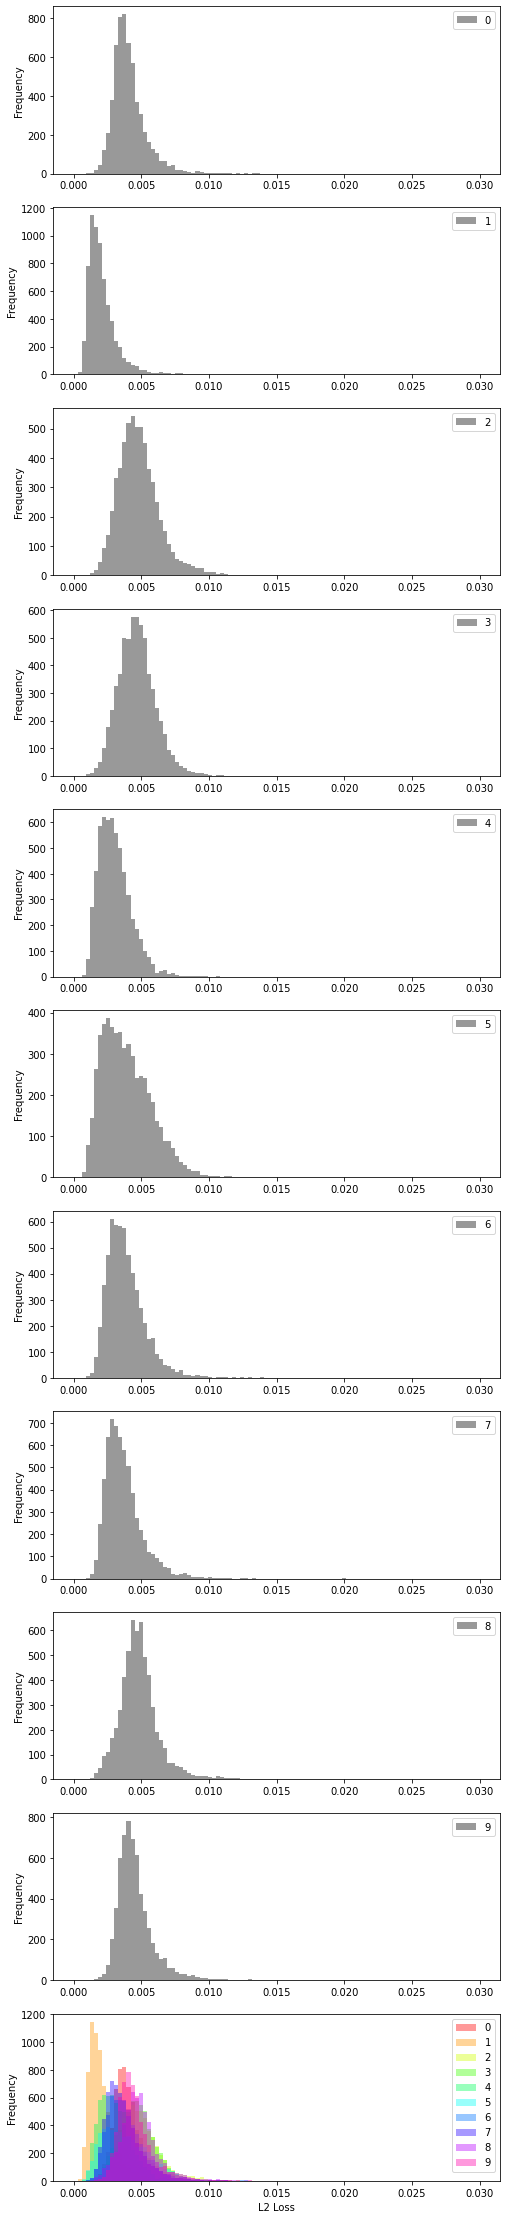

In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

losses = np.array(losses)
digits = np.array(digits)

plt.figure(figsize=(8, 40))
for i in range(10):
    plt.subplot(11, 1, i+1)
    plt.hist(losses[digits==i], range=(0, 0.03), label=str(i), bins=100, color='k', alpha=0.4)
    plt.legend()
    plt.ylabel('Frequency')

    
    plt.subplot(11, 1, 11)
    color = cm.hsv(i/10)
    plt.hist(losses[digits==i], range=(0, 0.03), label=str(i), bins=100, color=color, alpha=0.4)

plt.legend()
plt.xlabel('L2 Loss')
plt.ylabel('Frequency')
plt.show()